In [ ]:
# http://localhost:8888/notebooks/Google%20Drive/jupyter%20template/mp_view_cart_jukwaa_migration.ipynb

In [1]:
from pyhive import presto

def get_presto_conn():
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086)

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()
conn = get_presto_conn() 

import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [7]:
start_date = '2022-01-13'
end_date = '2022-01-25'
test_name = 'mp_mweb_best_seller_label'
control = 'control'
treatment = 'treatment'
# device_cat = "('Personal computer')" 
device_cat = "('Tablet','Smartphone')"
tmp_user_table1 = 'wandajuan.visitor_base_' + test_name
tmp_user_table2 = 'wandajuan.mp_metrics_' + test_name
tmp_user_table4 = 'wandajuan.xo_metrics_' + test_name
tmp_user_table3 = 'wandajuan.' + test_name

In [8]:
# Test user base:

print('run query below in presto:')

q = """
CREATE TABLE {tmp_user_table1} AS
with first_trigger as
    (
    SELECT 
       visitor_id
       , min(test_variant) as test_value_min
       , max(test_variant) as test_value_max
       , min(dt) as ft_dt
    FROM l2.test_selection
    WHERE test_name = '{test_name}'
    and dt BETWEEN '{start_date}' AND '{end_date}'
    and visitor_id in (
                        select distinct visitor_id
                            from l2.session_analytics core 
                        WHERE core.dt BETWEEN '{start_date}' AND '{end_date}'
                          and CAST(country as varchar) in ('US') 
                          and CAST(site_id as varchar) in ('101') 
                          AND device_cat != '' 
                          AND (test_set like '%{test_name}=%') 
                          and device_cat in {device_cat}
                          and session_id not in (
                                            select session_id 
                                            from l2.session_summary 
                                            where user_agent like '%test_automation%' 
                                            and dt>= '{start_date}') 
                      )
    group by visitor_id
    having min(test_variant) = max(test_variant)
    )
    SELECT visitor_id,test_value_min as test_variant, ft_dt as dt
    FROM first_trigger
""".format(tmp_user_table1=tmp_user_table1,
            test_name=test_name,
            start_date=start_date,
            end_date=end_date,
              device_cat = device_cat)

print(q)
pd.read_sql(q, conn)

run query below in presto:

CREATE TABLE wandajuan.visitor_base_mp_mweb_best_seller_label AS
with first_trigger as
    (
    SELECT 
       visitor_id
       , min(test_variant) as test_value_min
       , max(test_variant) as test_value_max
       , min(dt) as ft_dt
    FROM l2.test_selection
    WHERE test_name = 'mp_mweb_best_seller_label'
    and dt BETWEEN '2022-01-13' AND '2022-01-25'
    and visitor_id in (
                        select distinct visitor_id
                            from l2.session_analytics core 
                        WHERE core.dt BETWEEN '2022-01-13' AND '2022-01-25'
                          and CAST(country as varchar) in ('US') 
                          and CAST(site_id as varchar) in ('101') 
                          AND device_cat != '' 
                          AND (test_set like '%mp_mweb_best_seller_label=%') 
                          and device_cat in ('Tablet','Smartphone')
                          and session_id not in (
                   

,rows
0,486317


In [9]:
pd.read_sql("""Select test_variant,  count(visitor_id) from {tmp_user_table1} group by 1 order by 1""".format(tmp_user_table1=tmp_user_table1),conn)

,test_variant,_col1
0,control,212191
1,treatment_a,210933
2,treatment_b,63193


In [11]:
pd.read_sql("""Select * from {tmp_user_table1} limit 5""".format(tmp_user_table1=tmp_user_table1),conn)

,visitor_id,test_variant,dt
0,2915fb2e-757b-446c-aa48-a732f3e1ba79,control,2022-01-21
1,30843c51-171d-47b7-b36c-7cc045f92b28,treatment_a,2022-01-20
2,685f237d-f394-4ba5-a8ea-bb6fad4f3997,control,2022-01-21
3,944d6655-06f7-4fc8-9e4c-420fde9f65c0,control,2022-01-18
4,c1db7547-cc32-409c-88a3-870633fb0d18,treatment_a,2022-01-21


In [13]:
df1 = pd.read_sql("""Select dt, test_variant,  count(visitor_id) as visitor_cnt from {tmp_user_table1} group by 1, 2 order by 1, 2""".format(tmp_user_table1=tmp_user_table1),conn)
pd.pivot_table(df1, 'visitor_cnt', 'dt', 'test_variant')

test_variant,control,treatment_a,treatment_b
dt,,,
2022-01-13,10259,10101,3046
2022-01-14,8683,8474,2505
2022-01-15,11656,11480,3462
2022-01-16,13189,13530,3925
2022-01-17,12057,11854,3604
2022-01-18,14264,14023,4228
2022-01-19,21619,21331,6534
2022-01-20,21360,21398,6424
2022-01-21,18228,18178,5427


In [14]:
# MP Metrics:

print('run query below in presto:')

q = """
CREATE TABLE {tmp_user_table2} AS

select 
  t0.visitor_id, 
  t2.dt,
    count(distinct case when checkout_type = 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as new_orders,
    count(distinct case when checkout_type != 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as old_orders,
    
    count(distinct case when billing_info like '%paymentMethodType":0%' then t2.order_id end) as cc_orders,
    count(distinct case when billing_info like '%paymentMethodType":1%' then t2.order_id end) as apple_pay_orders,
    count(distinct case when billing_info like '%paymentMethodType":4%' then t2.order_id end) as afterpay_orders,
    count(distinct case when billing_info like '%paymentMethodType":3%' then t2.order_id end) as paypal_orders,
    
    sum(case when billing_info like '%paymentMethodType":0%' then t2.item_gmv end) as cc_gmv,
    sum(case when billing_info like '%paymentMethodType":1%' then t2.item_gmv end) as apple_pay_gmv,
    sum(case when billing_info like '%paymentMethodType":4%' then t2.item_gmv end) as afterpay_gmv,
    sum(case when billing_info like '%paymentMethodType":3%' then t2.item_gmv end) as paypal_gmv,
    
    count(distinct t2.order_id) as order_numbers, 
    sum(t2.item_gmv) as order_gmv
from {tmp_user_table1} t0 
join  mp_test.order_item_details t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.order_date >= t0.dt 
  and order_date between '{start_date}' and '{end_date}' 
join logs.marketplace_valid_orders_detailed_daily t4
    on t2.order_id = t4.order_id
where t2.status in (0,1,2,3,4,5,20,99) 
  and t2.is_impersonated = 0 
  -- and is_trade_program = 0
GROUP BY 1 ,2
""".format(tmp_user_table1=tmp_user_table1,
           tmp_user_table2 = tmp_user_table2,
           start_date=start_date,
           end_date=end_date)

print(q)
# pd.read_sql(q, conn)

run query below in presto:

CREATE TABLE wandajuan.mp_metrics_mp_mweb_best_seller_label AS

select 
  t0.visitor_id, 
  t2.dt,
    count(distinct case when checkout_type = 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as new_orders,
    count(distinct case when checkout_type != 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as old_orders,
    
    count(distinct case when billing_info like '%paymentMethodType":0%' then t2.order_id end) as cc_orders,
    count(distinct case when billing_info like '%paymentMethodType":1%' then t2.order_id end) as apple_pay_orders,
    count(distinct case when billing_info like '%paymentMethodType":4%' then t2.order_id end) as afterpay_orders,
    count(distinct case when billing_info like '%paymentMethodType":3%' then t2.order_id end) as paypal_orders,
    
    sum(case when billing_info like '%paymentMethodType":0%' then t2.item_gmv end) as cc_gmv,
    sum(case when billing_info like '%paymentMethodType":1%' then t2.item_gmv end) as apple_pay_g

In [111]:
df_mp = pd.read_sql("""
        select dt, test_group, bucket_id_visitor, 
                count(*) n_sess, 
                count(distinct visitor_id) n_visitor,
                sum(gmv_w_coupon) gmv_w_coupon,
                sum(order_numbers) order_numbers,
                sum(profit_w_coupon) profit_w_coupon
        from abtest.mp_web_visitor_metrics 
        where test_name = 'mp_dweb_external_reviews_v2'
        and dt >= '2021-10-21'
        and device_cat = 'Personal computer'
        and site = '101'
        group by 1, 2, 3
        order by 1, 2, 3
        """, conn)

In [112]:
print(df_mp.shape)
df_mp.head()

(1199, 8)


,dt,test_group,bucket_id_visitor,n_sess,n_visitor,gmv_w_coupon,order_numbers,profit_w_coupon
0,2021-10-21,control,0,17,17,0.0,0,0.0
1,2021-10-21,control,1,19,18,0.0,0,0.0
2,2021-10-21,control,10,15,14,0.0,0,0.0
3,2021-10-21,control,11,14,13,0.0,0,0.0
4,2021-10-21,control,12,16,13,0.0,0,0.0


In [113]:
df_engagement = pd.read_sql("""
                select dt, test_group, bucket_id_visitor, 
                        count(*) n_sess, 
                        count(distinct visitor_id) n_visitor,
                        sum(time_on_site) time_on_site,
                        sum(browse_products) browse_products,
                        sum(view_product) view_product,
                        sum(lb_view_product) lb_view_product,
                        sum(quick_view_products) quick_view_products,
                        sum(add_product_to_ideabook) add_product_to_ideabook,
                        sum(cart_add) cart_add,
                        sum(checkout_launch) checkout_launch,
                        sum(checkout_order_confirmation) checkout_order_confirmation
                from abtest.web_visitor_metrics 
                where test_name = 'mp_dweb_external_reviews_v2'
                and dt >= '2021-10-21'
                and device_cat = 'Personal computer'
                and site = '101'
                group by 1, 2, 3
                """, conn)

In [114]:
print(df_engagement.shape)
df_engagement.head()

(1199, 14)


,dt,test_group,bucket_id_visitor,n_sess,n_visitor,time_on_site,browse_products,view_product,lb_view_product,quick_view_products,add_product_to_ideabook,cart_add,checkout_launch,checkout_order_confirmation
0,2021-10-24,control,93,200,94,588.650000,184,123,0,9,1,9,1,0
1,2021-10-24,control,56,182,87,418.116667,198,225,0,8,16,9,4,2
2,2021-10-24,treatmentB,41,178,83,447.183333,164,163,0,1,11,2,1,0
3,2021-10-24,control,86,232,110,566.100000,361,353,0,3,2,13,2,2
4,2021-10-24,treatment,38,186,91,532.566667,118,144,2,5,1,1,1,1


In [115]:
df_metrics = df_mp.merge(df_engagement, how='outer', on=['dt', 'test_group', 'bucket_id_visitor'], suffixes=('_mp', '_eng'))
df_metrics

,dt,test_group,bucket_id_visitor,n_sess_mp,n_visitor_mp,gmv_w_coupon,order_numbers,profit_w_coupon,n_sess_eng,n_visitor_eng,time_on_site,browse_products,view_product,lb_view_product,quick_view_products,add_product_to_ideabook,cart_add,checkout_launch,checkout_order_confirmation
0,2021-10-21,control,0,17,17,0.00,0,0.0000,34,17,17.816667,11,18,0,0,0,0,0,0
1,2021-10-21,control,1,19,18,0.00,0,0.0000,38,18,58.333333,9,16,0,0,0,0,0,0
2,2021-10-21,control,10,15,14,0.00,0,0.0000,30,14,144.900000,8,65,0,0,0,0,0,0
3,2021-10-21,control,11,14,13,0.00,0,0.0000,26,13,95.166667,13,25,0,0,0,2,0,0
4,2021-10-21,control,12,16,13,0.00,0,0.0000,28,13,28.650000,19,19,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,2021-10-24,treatmentB,95,82,71,876.00,1,277.2806,152,71,646.733333,121,138,0,12,0,1,1,1
1195,2021-10-24,treatmentB,96,78,72,0.00,0,0.0000,146,72,235.783333,125,86,0,2,0,0,1,0
1196,2021-10-24,treatmentB,97,85,78,87.98,1,15.8364,160,78,485.533333,182,141,0,3,0,7,2,1
1197,2021-10-24,treatmentB,98,117,105,678.65,2,142.9970,220,105,795.816667,246,219,15,5,4,8,3,2


In [116]:
df_metrics.to_clipboard()

In [117]:
metrics_cols = [col for col in df_metrics.columns \
            if col not in ['dt', 'test_group', 'bucket_id_visitor', 'n_sess_mp', 'n_visitor_mp', \
                           'n_sess_eng','n_visitor_eng']]
df_metrics[metrics_cols]

,gmv_w_coupon,order_numbers,profit_w_coupon,time_on_site,browse_products,view_product,lb_view_product,quick_view_products,add_product_to_ideabook,cart_add,checkout_launch,checkout_order_confirmation
0,0.00,0,0.0000,17.816667,11,18,0,0,0,0,0,0
1,0.00,0,0.0000,58.333333,9,16,0,0,0,0,0,0
2,0.00,0,0.0000,144.900000,8,65,0,0,0,0,0,0
3,0.00,0,0.0000,95.166667,13,25,0,0,0,2,0,0
4,0.00,0,0.0000,28.650000,19,19,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1194,876.00,1,277.2806,646.733333,121,138,0,12,0,1,1,1
1195,0.00,0,0.0000,235.783333,125,86,0,2,0,0,1,0
1196,87.98,1,15.8364,485.533333,182,141,0,3,0,7,2,1
1197,678.65,2,142.9970,795.816667,246,219,15,5,4,8,3,2


In [118]:
avg_cols = ['avg_'+col for col in df_metrics.columns \
            if col not in ['dt', 'test_group', 'bucket_id_visitor', 'n_sess_mp', 'n_visitor_mp', \
                           'n_sess_eng','n_visitor_eng']]
avg_cols

['avg_gmv_w_coupon',
 'avg_order_numbers',
 'avg_profit_w_coupon',
 'avg_time_on_site',
 'avg_browse_products',
 'avg_view_product',
 'avg_lb_view_product',
 'avg_quick_view_products',
 'avg_add_product_to_ideabook',
 'avg_cart_add',
 'avg_checkout_launch',
 'avg_checkout_order_confirmation']

In [119]:
df_metrics[avg_cols] = df_metrics[metrics_cols].div(df_metrics['n_visitor_mp'], axis=0)
df_metrics

,dt,test_group,bucket_id_visitor,n_sess_mp,n_visitor_mp,gmv_w_coupon,order_numbers,profit_w_coupon,n_sess_eng,n_visitor_eng,time_on_site,browse_products,view_product,lb_view_product,quick_view_products,add_product_to_ideabook,cart_add,checkout_launch,checkout_order_confirmation,avg_gmv_w_coupon,avg_order_numbers,avg_profit_w_coupon,avg_time_on_site,avg_browse_products,avg_view_product,avg_lb_view_product,avg_quick_view_products,avg_add_product_to_ideabook,avg_cart_add,avg_checkout_launch,avg_checkout_order_confirmation
0,2021-10-21,control,0,17,17,0.00,0,0.0000,34,17,17.816667,11,18,0,0,0,0,0,0,0.000000,0.000000,0.000000,1.048039,0.647059,1.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2021-10-21,control,1,19,18,0.00,0,0.0000,38,18,58.333333,9,16,0,0,0,0,0,0,0.000000,0.000000,0.000000,3.240741,0.500000,0.888889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2021-10-21,control,10,15,14,0.00,0,0.0000,30,14,144.900000,8,65,0,0,0,0,0,0,0.000000,0.000000,0.000000,10.350000,0.571429,4.642857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2021-10-21,control,11,14,13,0.00,0,0.0000,26,13,95.166667,13,25,0,0,0,2,0,0,0.000000,0.000000,0.000000,7.320513,1.000000,1.923077,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000
4,2021-10-21,control,12,16,13,0.00,0,0.0000,28,13,28.650000,19,19,0,1,0,0,0,0,0.000000,0.000000,0.000000,2.203846,1.461538,1.461538,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,2021-10-24,treatmentB,95,82,71,876.00,1,277.2806,152,71,646.733333,121,138,0,12,0,1,1,1,12.338028,0.014085,3.905361,9.108920,1.704225,1.943662,0.000000,0.169014,0.000000,0.014085,0.014085,0.014085
1195,2021-10-24,treatmentB,96,78,72,0.00,0,0.0000,146,72,235.783333,125,86,0,2,0,0,1,0,0.000000,0.000000,0.000000,3.274769,1.736111,1.194444,0.000000,0.027778,0.000000,0.000000,0.013889,0.000000
1196,2021-10-24,treatmentB,97,85,78,87.98,1,15.8364,160,78,485.533333,182,141,0,3,0,7,2,1,1.127949,0.012821,0.203031,6.224786,2.333333,1.807692,0.000000,0.038462,0.000000,0.089744,0.025641,0.012821
1197,2021-10-24,treatmentB,98,117,105,678.65,2,142.9970,220,105,795.816667,246,219,15,5,4,8,3,2,6.463333,0.019048,1.361876,7.579206,2.342857,2.085714,0.142857,0.047619,0.038095,0.076190,0.028571,0.019048


In [120]:
def calculate(input_df, col_list, control, treatment):
    slices = 'All'
    slice_value = 'All'
    columns = ['Metric', 'Treatment Size', 'Treatment Total', 'Treatment Mean',
               'Control Size', 'Control Total', 'Control Mean', 'P-value']

    ctl_size = input_df[(input_df['test_group'] == control)] ['n_visitor_mp'].sum()
    trt_size = input_df[(input_df['test_group'] == treatment)] ['n_visitor_mp'].sum()
    total_sample_size = ctl_size + trt_size

    df_egg_overall = pd.DataFrame(columns=columns)
    for metric in col_list:
        ctl = input_df[(input_df['test_group'] == control)][metric]
        trt = input_df[(input_df['test_group'] == treatment)][metric]
        
        ctl_total = (input_df[(input_df['test_group'] == control)][metric]*input_df[(input_df['test_group'] == control)]['n_visitor_mp']).sum()
        trt_total = (input_df[(input_df['test_group'] == treatment)][metric]*input_df[(input_df['test_group'] == treatment)]['n_visitor_mp']).sum()
        
        row = [metric, trt_size, trt_total, trt.mean(), ctl_size, ctl_total, ctl.mean(), stats.ttest_ind(ctl, trt).pvalue]
        df_egg_overall = df_egg_overall.append(pd.Series(row, index=columns), ignore_index=True)
        
    df_egg_overall['Lift'] =\
        df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean']
    df_egg_overall['Lift_%'] =\
        (df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean'])/ (df_egg_overall['Control Mean']+1e-12)
    return df_egg_overall[['Metric','Treatment Size', 'Treatment Total', 'Treatment Mean', 'Control Size', 
                           'Control Total', 'Control Mean', 'Lift', 'Lift_%','P-value']]

calculate(df_metrics, avg_cols, 'control', 'treatment')

,Metric,Treatment Size,Treatment Total,Treatment Mean,Control Size,Control Total,Control Mean,Lift,Lift_%,P-value
0,avg_gmv_w_coupon,28626,148848.240000,4.265836,28669,137447.940000,5.489194,-1.223358,-0.222867,0.255018
1,avg_order_numbers,28626,352.000000,0.011660,28669,299.000000,0.011227,0.000432,0.038488,0.827647
2,avg_profit_w_coupon,28626,33553.475000,0.950800,28669,34152.955100,1.417617,-0.466817,-0.329297,0.153294
3,avg_time_on_site,28626,137513.633333,5.133909,28669,132789.333333,4.781494,0.352415,0.073704,0.118354
4,avg_browse_products,28626,50724.000000,1.801998,28669,50708.000000,1.824751,-0.022753,-0.012469,0.759521
5,avg_view_product,28626,54512.000000,2.032953,28669,53292.000000,1.898990,0.133963,0.070544,0.054130
6,avg_lb_view_product,28626,207.000000,0.007386,28669,205.000000,0.006373,0.001014,0.159072,0.709090
7,avg_quick_view_products,28626,2152.000000,0.072921,28669,1949.000000,0.064867,0.008053,0.124154,0.273486
8,avg_add_product_to_ideabook,28626,773.000000,0.022227,28669,593.000000,0.019379,0.002849,0.146994,0.486003
9,avg_cart_add,28626,2041.000000,0.084356,28669,1896.000000,0.073303,0.011052,0.150775,0.279427


In [110]:
calculate(df_metrics, avg_cols, 'control', 'treatment').to_clipboard()

In [2]:
# INPUT:


start_date = '2021-10-12'
end_date = '2021-10-23'
test_name = 'dweb_lowest_price_badge_test'
control = 'control'
treatment = 'treatment'
device_cat = "('Personal computer')" 
# device_cat = "('Tablet','Smartphone')"
tmp_user_table1 = 'wandajuan.visitor_base_' + test_name
tmp_user_table2 = 'wandajuan.mp_metrics_' + test_name
tmp_user_table4 = 'wandajuan.xo_metrics_' + test_name
tmp_user_table3 = 'wandajuan.' + test_name

In [3]:
pd.read_sql("""DROP TABLE IF EXISTS {tmp_user_table1}""".format(tmp_user_table1=tmp_user_table1), conn)

,result
0,True


In [4]:
# Test user base:

print('run query below in impala:')

q = """
CREATE TABLE {tmp_user_table1} AS
with first_trigger as
    (
    SELECT 
       visitor_id
       , min(test_variant) as test_value_min
       , max(test_variant) as test_value_max
       , min(dt) as ft_dt
    FROM l2.test_selection
    WHERE test_name = '{test_name}'
    and dt BETWEEN '{start_date}' AND '{end_date}'
    and dt not between '2021-05-10' and '2021-05-11'
    and dt != '2021-06-07'
    and visitor_id in (select distinct visitor_id
    from l2.session_analytics core 
WHERE core.dt BETWEEN '{start_date}' AND '{end_date}'
    and core.dt not between '2021-05-10' and '2021-05-11'
    and core.dt != '2021-06-07'
  and CAST(country as varchar) in ('US') 
  and CAST(site_id as varchar) in ('101') 
  AND device_cat != '' 
  AND (test_set like '%{test_name}=%') 
  and device_cat in {device_cat}
  and session_id not in (
                    select session_id 
                    from l2.session_summary 
                    where user_agent like '%test_automation%' 
                    and dt>= '{start_date}') 
  )
    group by visitor_id
    having min(test_variant) = max(test_variant)
    )
    SELECT visitor_id,test_value_min as test_variant, ft_dt as dt
    FROM first_trigger
""".format(tmp_user_table1=tmp_user_table1,
            test_name=test_name,
            start_date=start_date,
            end_date=end_date,
              device_cat = device_cat)

print(q)
pd.read_sql(q, conn)

run query below in impala:

CREATE TABLE wandajuan.visitor_base_dweb_lowest_price_badge_test AS
with first_trigger as
    (
    SELECT 
       visitor_id
       , min(test_variant) as test_value_min
       , max(test_variant) as test_value_max
       , min(dt) as ft_dt
    FROM l2.test_selection
    WHERE test_name = 'dweb_lowest_price_badge_test'
    and dt BETWEEN '2021-10-12' AND '2021-10-23'
    and dt not between '2021-05-10' and '2021-05-11'
    and dt != '2021-06-07'
    and visitor_id in (select distinct visitor_id
    from l2.session_analytics core 
WHERE core.dt BETWEEN '2021-10-12' AND '2021-10-23'
    and core.dt not between '2021-05-10' and '2021-05-11'
    and core.dt != '2021-06-07'
  and CAST(country as varchar) in ('US') 
  and CAST(site_id as varchar) in ('101') 
  AND device_cat != '' 
  AND (test_set like '%dweb_lowest_price_badge_test=%') 
  and device_cat in ('Personal computer')
  and session_id not in (
                    select session_id 
                    

,rows
0,57507


In [17]:
# daily visitor test variant map
pd.read_sql('select * from {tmp_user_table1} limit 5'.format(tmp_user_table1=tmp_user_table1), conn)

,visitor_id,test_variant,dt
0,c6c40c92-f01f-4faa-8da9-bbf0ad1a9aac,control,2021-10-14
1,b9acda87-c624-486e-aa34-09a0fb04f820,control,2021-10-19
2,079e6ce2-9540-45ef-8b12-1cd72fcbc197,treatment,2021-10-14
3,15a3edac-6913-4105-ac61-923de278c6b2,treatment,2021-10-17
4,a0bad1d1-6dcb-4df8-a4d5-84694900bd5c,control,2021-10-17


In [5]:
# check total number of distinct visitors
pd.read_sql("""Select count(*), count(distinct visitor_id) from {tmp_user_table1}""".format(tmp_user_table1=tmp_user_table1), conn)

,_col0,_col1
0,57507,57507


In [6]:
# check number of distinct visitors per test variant
pd.read_sql("""Select test_variant,  count(visitor_id) from {tmp_user_table1} group by 1 order by 1""".format(tmp_user_table1=tmp_user_table1),conn)

,test_variant,_col1
0,control,28955
1,treatment,28552


In [18]:
pd.read_sql("""DROP TABLE IF EXISTS {tmp_user_table4}""".format(tmp_user_table4=tmp_user_table4), conn)

,result
0,True


In [19]:
# Checkout Metrics:

print('run query below in presto:')

q = """
CREATE TABLE {tmp_user_table4} AS

select 
  t0.visitor_id, 
  t0.test_variant,
  t2.dt,
  sum(t2.cart_add) as cart_add,
  sum(t2.view_cart) as view_cart,
  count(distinct case when t2.view_cart>0 then session_id end) as view_cart_sessions,
  sum(t2.checkout_launch) as checkout_launch,
  sum(t2.checkout_shipping) as checkout_shipping,
  sum(t2.checkout_billing_and_payment) as checkout_billing_and_payment,
  sum(t2.checkout_order_review) as checkout_order_review,
  count(distinct case when t2.checkout_order_review>0 then session_id end) as xo_review_sessions,
  sum(t2.checkout_order_confirmation) as checkout_order_confirmation

from {tmp_user_table1} t0 
join l2.session_analytics t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '{start_date}' and '{end_date}' 
and t2.dt not between '2021-05-10' and '2021-05-11'
and t2.dt != '2021-06-07'
GROUP BY 1, 2, 3
""".format(tmp_user_table1=tmp_user_table1,
           tmp_user_table4 = tmp_user_table4,
           start_date=start_date,
           end_date=end_date)

print(q)
pd.read_sql(q, conn)

run query below in presto:

CREATE TABLE wandajuan.xo_metrics_dweb_lowest_price_badge_test AS

select 
  t0.visitor_id, 
  t0.test_variant,
  t2.dt,
  sum(t2.cart_add) as cart_add,
  sum(t2.view_cart) as view_cart,
  count(distinct case when t2.view_cart>0 then session_id end) as view_cart_sessions,
  sum(t2.checkout_launch) as checkout_launch,
  sum(t2.checkout_shipping) as checkout_shipping,
  sum(t2.checkout_billing_and_payment) as checkout_billing_and_payment,
  sum(t2.checkout_order_review) as checkout_order_review,
  count(distinct case when t2.checkout_order_review>0 then session_id end) as xo_review_sessions,
  sum(t2.checkout_order_confirmation) as checkout_order_confirmation

from wandajuan.visitor_base_dweb_lowest_price_badge_test t0 
join l2.session_analytics t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '2021-10-12' and '2021-10-23' 
and t2.dt not between '2021-05-10' and '2021-05-11'
and t2.dt != '2021-06-07'
GROUP BY 1, 2, 3



,rows
0,72296


In [20]:
# daily visitor checkout metrics
pd.read_sql('select * from {tmp_user_table4} limit 5'.format(tmp_user_table4=tmp_user_table4), conn)

,visitor_id,test_variant,dt,cart_add,view_cart,view_cart_sessions,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,xo_review_sessions,checkout_order_confirmation
0,479c04a0-0f57-47ed-b105-f4f9fa31174f,control,2021-10-23,0,0,0,0,0,0,0,0,0
1,9b098e54-caa8-405f-b000-ebb75e4eab40,control,2021-10-20,6,4,1,2,2,0,5,1,1
2,33a45ee6-07f3-48df-9c8d-ee88bac244e2,control,2021-10-22,0,0,0,0,0,0,0,0,0
3,e2dece14-27d2-4eaa-af30-06cf1535e3fc,treatment,2021-10-21,0,0,0,0,0,0,0,0,0
4,71034ade-738c-42f1-b869-bcd3161aea2d,control,2021-10-18,0,0,0,0,0,0,0,0,0


In [23]:
# daily visitor checkout metrics
pd.read_sql("""
                select dt, test_variant, count(*) n_visitors, avg(cart_add) cart_add,
                avg(checkout_order_confirmation) checkout_order_confirmation
                from {tmp_user_table4} 
                group by 1, 2
                order by 1, 2
                """.format(tmp_user_table4=tmp_user_table4)
            , conn)

,dt,test_variant,n_visitors,cart_add,checkout_order_confirmation
0,2021-10-12,control,41,0.170732,0.048780
1,2021-10-12,treatment,34,0.058824,0.058824
2,2021-10-13,control,1157,0.230769,0.020743
3,2021-10-13,treatment,1188,0.134680,0.019360
4,2021-10-14,control,1502,0.214381,0.029294
5,2021-10-14,treatment,1462,0.212038,0.036936
6,2021-10-15,control,2073,0.220453,0.018813
7,2021-10-15,treatment,2024,0.174407,0.018281
8,2021-10-16,control,3212,0.190535,0.023973
9,2021-10-16,treatment,3052,0.199869,0.021298


In [24]:
pd.read_sql("""DROP TABLE IF EXISTS {tmp_user_table2}""".format(tmp_user_table2=tmp_user_table2), conn)

,result
0,True


In [25]:
# MP Metrics:

print('run query below in presto:')

q = """
CREATE TABLE {tmp_user_table2} AS

select 
  t0.visitor_id, 
  t0.test_variant,
  t2.dt,
    count(distinct case when checkout_type = 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as new_orders,
    count(distinct case when checkout_type != 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as old_orders,
    
    count(distinct case when billing_info like '%paymentMethodType":0%' then t2.order_id end) as cc_orders,
    count(distinct case when billing_info like '%paymentMethodType":1%' then t2.order_id end) as apple_pay_orders,
    count(distinct case when billing_info like '%paymentMethodType":4%' then t2.order_id end) as afterpay_orders,
    count(distinct case when billing_info like '%paymentMethodType":3%' then t2.order_id end) as paypal_orders,
    
    sum(case when billing_info like '%paymentMethodType":0%' then t2.item_gmv end) as cc_gmv,
    sum(case when billing_info like '%paymentMethodType":1%' then t2.item_gmv end) as apple_pay_gmv,
    sum(case when billing_info like '%paymentMethodType":4%' then t2.item_gmv end) as afterpay_gmv,
    sum(case when billing_info like '%paymentMethodType":3%' then t2.item_gmv end) as paypal_gmv,
    
  count(distinct t2.order_id) as order_numbers, 
  sum(t2.item_gmv) as order_gmv
from {tmp_user_table1} t0 
join  mp_test.order_item_details t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.order_date >= t0.dt 
  and order_date between '{start_date}' and '{end_date}' 
join logs.marketplace_valid_orders_detailed_daily t4
    on t2.order_id = t4.order_id
where t2.status in (0,1,2,3,4,5,20,99) 
  and t2.is_impersonated = 0 
  -- and is_trade_program = 0
GROUP BY 1, 2, 3
""".format(tmp_user_table1=tmp_user_table1,
           tmp_user_table2 = tmp_user_table2,
           start_date=start_date,
           end_date=end_date)

print(q)
pd.read_sql(q, conn)

run query below in presto:

CREATE TABLE wandajuan.mp_metrics_dweb_lowest_price_badge_test AS

select 
  t0.visitor_id, 
  t0.test_variant,
  t2.dt,
    count(distinct case when checkout_type = 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as new_orders,
    count(distinct case when checkout_type != 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as old_orders,
    
    count(distinct case when billing_info like '%paymentMethodType":0%' then t2.order_id end) as cc_orders,
    count(distinct case when billing_info like '%paymentMethodType":1%' then t2.order_id end) as apple_pay_orders,
    count(distinct case when billing_info like '%paymentMethodType":4%' then t2.order_id end) as afterpay_orders,
    count(distinct case when billing_info like '%paymentMethodType":3%' then t2.order_id end) as paypal_orders,
    
    sum(case when billing_info like '%paymentMethodType":0%' then t2.item_gmv end) as cc_gmv,
    sum(case when billing_info like '%paymentMethodType":1%' then t2.item_g

,rows
0,1632


In [26]:
# daily visitor MP metrics
pd.read_sql('select * from {tmp_user_table2} limit 5'.format(tmp_user_table2=tmp_user_table2), conn)

,visitor_id,test_variant,dt,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,order_numbers,order_gmv
0,74dffc27-3297-465a-87fd-6813e8ce83de,treatment,2021-10-21,0,1,1,0,0,0,554.00,None,None,NaN,1,554.00
1,66c2a879-cbfd-4849-a81a-6cf9f63ddd3a,control,2021-10-17,1,0,1,0,0,0,1472.00,None,None,NaN,1,1472.00
2,acdc8c46-f66b-492d-bb5d-445ba17b698e,control,2021-10-18,1,0,1,0,0,0,933.30,None,None,NaN,1,933.30
3,146e249c-63ce-4993-abb5-d09cdbfe9c15,control,2021-10-18,0,1,1,0,0,0,3983.96,None,None,NaN,1,3983.96
4,78904e55-8fcd-4de8-9449-ad79b3019d11,control,2021-10-20,3,0,0,0,0,3,NaN,None,None,1654.15,3,1654.15


In [27]:
# daily test variant's MP metrics
pd.read_sql("""
                select dt, test_variant, count(*) n_visitors, avg(order_numbers) order_numbers,
                avg(order_gmv) order_gmv
                from {tmp_user_table2} 
                group by 1, 2
                order by 1, 2
                """.format(tmp_user_table2=tmp_user_table2)
            , conn)

,dt,test_variant,n_visitors,order_numbers,order_gmv
0,2021-10-12,control,2,1.000000,52.995000
1,2021-10-12,treatment,1,1.000000,196.000000
2,2021-10-13,control,23,1.565217,496.870435
3,2021-10-13,treatment,21,1.428571,745.613810
4,2021-10-14,control,34,1.264706,430.832059
5,2021-10-14,treatment,49,1.367347,552.375510
6,2021-10-15,control,32,1.312500,419.636875
7,2021-10-15,treatment,36,1.444444,755.733611
8,2021-10-16,control,69,1.536232,614.928261
9,2021-10-16,treatment,64,1.296875,531.447187


In [28]:
pd.read_sql("""Select count(distinct visitor_id), sum(order_numbers), sum(order_gmv) from  {tmp_user_table2}"""
            .format(tmp_user_table2=tmp_user_table2),conn)

,_col0,_col1,_col2
0,1577,2224,944301.59


In [29]:
pd.read_sql("""DROP TABLE IF EXISTS {tmp_user_table3}""".format(tmp_user_table3=tmp_user_table3), conn)

,result
0,True


In [30]:
# Final Table:

print('run query below in presto:')

q = """
CREATE TABLE {tmp_user_table3} AS

select 
    base.date as dt,
    c.visitor_id, 
    case when c.test_variant like 'treatment%' then 'treatment' 
        when c.test_variant like 'control%' then 'control' else 'not_in_test' end as test_variant,
    c.dt as first_trigger_dt,
    coalesce(va.order_numbers,0) as order_numbers,
    coalesce(va.order_gmv,0) as order_gmv,
    coalesce(va.new_orders,0) as new_orders,
    coalesce(va.old_orders,0) as old_orders,
    coalesce(cc_orders, 0) as cc_orders,
    coalesce(apple_pay_orders, 0) as apple_pay_orders,
    coalesce(afterpay_orders, 0) as afterpay_orders,
    coalesce(paypal_orders, 0) as paypal_orders,
    coalesce(cc_gmv, 0) as cc_gmv,
    coalesce(apple_pay_gmv, 0) as apple_pay_gmv,
    coalesce(afterpay_gmv, 0) as afterpay_gmv,
    coalesce(paypal_gmv, 0) as paypal_gmv,
    coalesce(sm.cart_add,0) as cart_add,
    coalesce(sm.view_cart,0) as view_cart,
    coalesce(sm.view_cart_sessions,0) as view_cart_sessions,
    coalesce(sm.checkout_launch,0) as checkout_launch,
    coalesce(sm.checkout_shipping,0) as checkout_shipping,
    coalesce(sm.checkout_billing_and_payment,0) as checkout_billing_and_payment,
    coalesce(sm.checkout_order_review,0) as checkout_order_review,
    coalesce(sm.xo_review_sessions,0) as xo_review_sessions,
    coalesce(sm.checkout_order_confirmation,0) as checkout_order_confirmation
from mp.cal_dim base  
join {tmp_user_table1} c  
    on 1=1
left JOIN {tmp_user_table2} va
    ON c.visitor_id = va.visitor_id
    and base.date = va.dt
    and order_gmv <= 10000
left join {tmp_user_table4} sm
    on c.visitor_id = sm.visitor_id
    and base.date = sm.dt
where base.date between '{start_date}' and '{end_date}' 
""".format(tmp_user_table4=tmp_user_table4,
           tmp_user_table3=tmp_user_table3,
            tmp_user_table2=tmp_user_table2,
            tmp_user_table1=tmp_user_table1,
            start_date=start_date,
            end_date=end_date)


print(q)
pd.read_sql(q, conn)

run query below in presto:

CREATE TABLE wandajuan.dweb_lowest_price_badge_test AS

select 
    base.date as dt,
    c.visitor_id, 
    case when c.test_variant like 'treatment%' then 'treatment' 
        when c.test_variant like 'control%' then 'control' else 'not_in_test' end as test_variant,
    c.dt as first_trigger_dt,
    coalesce(va.order_numbers,0) as order_numbers,
    coalesce(va.order_gmv,0) as order_gmv,
    coalesce(va.new_orders,0) as new_orders,
    coalesce(va.old_orders,0) as old_orders,
    coalesce(cc_orders, 0) as cc_orders,
    coalesce(apple_pay_orders, 0) as apple_pay_orders,
    coalesce(afterpay_orders, 0) as afterpay_orders,
    coalesce(paypal_orders, 0) as paypal_orders,
    coalesce(cc_gmv, 0) as cc_gmv,
    coalesce(apple_pay_gmv, 0) as apple_pay_gmv,
    coalesce(afterpay_gmv, 0) as afterpay_gmv,
    coalesce(paypal_gmv, 0) as paypal_gmv,
    coalesce(sm.cart_add,0) as cart_add,
    coalesce(sm.view_cart,0) as view_cart,
    coalesce(sm.view_cart_sessions

,rows
0,690084


In [31]:
# daily visitor MP metrics
pd.read_sql('select * from {tmp_user_table3} limit 5'.format(tmp_user_table3=tmp_user_table3), conn)

,dt,visitor_id,test_variant,first_trigger_dt,order_numbers,order_gmv,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,cart_add,view_cart,view_cart_sessions,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,xo_review_sessions,checkout_order_confirmation
0,2021-10-15,b9acda87-c624-486e-aa34-09a0fb04f820,control,2021-10-19,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
1,2021-10-17,b9acda87-c624-486e-aa34-09a0fb04f820,control,2021-10-19,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
2,2021-10-13,c6c40c92-f01f-4faa-8da9-bbf0ad1a9aac,control,2021-10-14,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
3,2021-10-14,c6c40c92-f01f-4faa-8da9-bbf0ad1a9aac,control,2021-10-14,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
4,2021-10-21,c6c40c92-f01f-4faa-8da9-bbf0ad1a9aac,control,2021-10-14,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0


In [32]:
pd.read_sql("""Select count(*), count(distinct visitor_id),sum(order_numbers),sum(order_gmv) from {tmp_user_table3}"""
            .format(tmp_user_table3=tmp_user_table3),conn)

,_col0,_col1,_col2,_col3
0,690084,57507,2221,932884.57


In [33]:
def add_pct(input_df, col):
    total = input_df[col].sum()
    input_df['percent_%'] = input_df[col] * 100.0 / total
    return input_df

In [34]:
df1 = pd.read_sql("""
SELECT test_variant, COUNT(distinct visitor_id) as visitors FROM {tmp_user_table1} 
GROUP BY 1 ORDER BY 1
""".format(tmp_user_table1=tmp_user_table1),conn)

df2 = add_pct(df1, 'visitors')
display(df2)

,test_variant,visitors,percent_%
0,control,28955,50.350392
1,treatment,28552,49.649608


In [18]:
df1 = pd.read_sql("""
SELECT dt, test_variant, COUNT(DISTINCT visitor_id) as visitors FROM {tmp_user_table3} GROUP BY 1, 2 order by 1,2
""".format(tmp_user_table3=tmp_user_table3),conn)

df1.head(10)
#df1.groupby('os').apply(lambda x: day_by_day(x, ['visitors'], control, treatment))

,dt,test_variant,visitors
0,2021-10-12,control,13660
1,2021-10-12,treatment,13368
2,2021-10-13,control,13660
3,2021-10-13,treatment,13368
4,2021-10-14,control,13660
5,2021-10-14,treatment,13368
6,2021-10-15,control,13660
7,2021-10-15,treatment,13368
8,2021-10-16,control,13660
9,2021-10-16,treatment,13368


In [35]:
df1 = pd.read_sql("""
SELECT * FROM {tmp_user_table3}  LIMIT 5
""".format(tmp_user_table3=tmp_user_table3), conn)
df1 = df1.fillna(0)
df1

,dt,visitor_id,test_variant,first_trigger_dt,order_numbers,order_gmv,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,cart_add,view_cart,view_cart_sessions,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,xo_review_sessions,checkout_order_confirmation
0,2021-10-21,0ea89f78-ed35-41ad-a6d3-af6a6cb95110,treatment,2021-10-18,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
1,2021-10-21,74dd9fff-198e-4326-a919-07f9e4bc1469,control,2021-10-18,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
2,2021-10-21,2070c209-c75e-4a0e-bf14-5b1290853dec,control,2021-10-18,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
3,2021-10-22,bf263efb-529c-4742-8d75-0fc106dee031,treatment,2021-10-17,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
4,2021-10-22,530ff9ec-bfe5-4c85-a382-28938443d3ed,treatment,2021-10-17,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0


In [36]:
col_list = df1.columns.values[4:]
sub_sum_q = '\n'.join(['    ,SUM({elem}) as {elem}'.format(elem=elem) for elem in col_list])

q = """
    SELECT test_variant
        , cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket
        , COUNT(DISTINCT visitor_id) as visitors
    {sub_sum_q}
    FROM {tmp_user_table3}
    GROUP BY 1, 2
""".format(tmp_user_table3=tmp_user_table3,sub_sum_q=sub_sum_q)

print(q)


    SELECT test_variant
        , cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket
        , COUNT(DISTINCT visitor_id) as visitors
        ,SUM(order_numbers) as order_numbers
    ,SUM(order_gmv) as order_gmv
    ,SUM(new_orders) as new_orders
    ,SUM(old_orders) as old_orders
    ,SUM(cc_orders) as cc_orders
    ,SUM(apple_pay_orders) as apple_pay_orders
    ,SUM(afterpay_orders) as afterpay_orders
    ,SUM(paypal_orders) as paypal_orders
    ,SUM(cc_gmv) as cc_gmv
    ,SUM(apple_pay_gmv) as apple_pay_gmv
    ,SUM(afterpay_gmv) as afterpay_gmv
    ,SUM(paypal_gmv) as paypal_gmv
    ,SUM(cart_add) as cart_add
    ,SUM(view_cart) as view_cart
    ,SUM(view_cart_sessions) as view_cart_sessions
    ,SUM(checkout_launch) as checkout_launch
    ,SUM(checkout_shipping) as checkout_shipping
    ,SUM(checkout_billing_and_payment) as checkout_billing_and_payment
    ,SUM(checkout_order_review) as checkout_order_review
    ,SUM(xo_review_sessions) as xo_review_sessions
    ,SUM(checkou

In [37]:
df_all = pd.read_sql(q,conn)

for col in col_list:
    df_all['avg_' + col] = df_all[col] / df_all['visitors']

In [38]:
df_dt = pd.read_sql("""
    SELECT test_variant
        ,dt
        ,COUNT(DISTINCT visitor_id) as visitors
    {sub_sum_q}
    FROM {tmp_user_table3}
    GROUP BY 1, 2
""".format(tmp_user_table3=tmp_user_table3,sub_sum_q=sub_sum_q), conn)
    
for col in col_list:
    df_dt['avg_' + col] = df_dt[col] / df_dt['visitors']

In [39]:
df_dt.sort_values(by=['dt', 'test_variant']).head()

,test_variant,dt,visitors,order_numbers,order_gmv,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,cart_add,view_cart,view_cart_sessions,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,xo_review_sessions,checkout_order_confirmation,avg_order_numbers,avg_order_gmv,avg_new_orders,avg_old_orders,avg_cc_orders,avg_apple_pay_orders,avg_afterpay_orders,avg_paypal_orders,avg_cc_gmv,avg_apple_pay_gmv,avg_afterpay_gmv,avg_paypal_gmv,avg_cart_add,avg_view_cart,avg_view_cart_sessions,avg_checkout_launch,avg_checkout_shipping,avg_checkout_billing_and_payment,avg_checkout_order_review,avg_xo_review_sessions,avg_checkout_order_confirmation
20,control,2021-10-12,28955,2,105.99,1,1,0,0,0,2,0.00,0.0,0.0,105.99,7,5,1,2,2,1,2,2,2,0.000069,0.003661,0.000035,0.000035,0.000000,0.0,0.000000,0.000069,0.000000,0.0,0.000000,0.003661,0.000242,0.000173,0.000035,0.000069,0.000069,0.000035,0.000069,0.000069,0.000069
12,treatment,2021-10-12,28552,1,196.00,0,1,1,0,0,0,196.00,0.0,0.0,0.00,2,1,1,2,2,0,5,1,2,0.000035,0.006865,0.000000,0.000035,0.000035,0.0,0.000000,0.000000,0.006865,0.0,0.000000,0.000000,0.000070,0.000035,0.000035,0.000070,0.000070,0.000000,0.000175,0.000035,0.000070
18,control,2021-10-13,28955,36,11428.02,10,26,30,0,0,6,8619.73,0.0,0.0,2808.29,267,217,96,62,49,28,60,28,24,0.001243,0.394682,0.000345,0.000898,0.001036,0.0,0.000000,0.000207,0.297694,0.0,0.000000,0.096988,0.009221,0.007494,0.003315,0.002141,0.001692,0.000967,0.002072,0.000967,0.000829
13,treatment,2021-10-13,28552,30,15657.89,11,19,30,0,0,0,15657.89,0.0,0.0,0.00,160,145,62,48,43,30,59,29,23,0.001051,0.548399,0.000385,0.000665,0.001051,0.0,0.000000,0.000000,0.548399,0.0,0.000000,0.000000,0.005604,0.005078,0.002171,0.001681,0.001506,0.001051,0.002066,0.001016,0.000806
21,control,2021-10-14,28955,43,14648.29,17,26,33,0,2,8,13211.38,0.0,263.0,1173.91,322,364,141,94,77,54,131,54,44,0.001485,0.505898,0.000587,0.000898,0.001140,0.0,0.000069,0.000276,0.456273,0.0,0.009083,0.040543,0.011121,0.012571,0.004870,0.003246,0.002659,0.001865,0.004524,0.001865,0.001520


In [40]:
avg_col_list = ['avg_'+c for c in col_list]

print(avg_col_list)

['avg_order_numbers', 'avg_order_gmv', 'avg_new_orders', 'avg_old_orders', 'avg_cc_orders', 'avg_apple_pay_orders', 'avg_afterpay_orders', 'avg_paypal_orders', 'avg_cc_gmv', 'avg_apple_pay_gmv', 'avg_afterpay_gmv', 'avg_paypal_gmv', 'avg_cart_add', 'avg_view_cart', 'avg_view_cart_sessions', 'avg_checkout_launch', 'avg_checkout_shipping', 'avg_checkout_billing_and_payment', 'avg_checkout_order_review', 'avg_xo_review_sessions', 'avg_checkout_order_confirmation']


In [41]:
# outputs t-test results on numerical values
def calculate(input_df, col_list, control, treatment):
    slices = 'All'
    slice_value = 'All'
    columns = ['Metric', 'Treatment Size', 'Treatment Total', 'Treatment Mean',
               'Control Size', 'Control Total', 'Control Mean', 'P-value']

    ctl_size = input_df[(input_df['test_variant'] == control)] ['visitors'].sum()
    trt_size = input_df[(input_df['test_variant'] == treatment)] ['visitors'].sum()
    total_sample_size = ctl_size + trt_size

    df_egg_overall = pd.DataFrame(columns=columns)
    for metric in col_list:
        ctl = input_df[(input_df['test_variant'] == control)][metric]
        trt = input_df[(input_df['test_variant'] == treatment)][metric]
        
        ctl_total = (input_df[(input_df['test_variant'] == control)][metric]*input_df[(input_df['test_variant'] == control)]['visitors']).sum()
        trt_total = (input_df[(input_df['test_variant'] == treatment)][metric]*input_df[(input_df['test_variant'] == treatment)]['visitors']).sum()
        
        row = [metric, trt_size, trt_total, trt.mean(), ctl_size, ctl_total, ctl.mean(), stats.ttest_ind(ctl, trt).pvalue]
        df_egg_overall = df_egg_overall.append(pd.Series(row, index=columns), ignore_index=True)
        
    df_egg_overall['Lift'] =\
        df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean']
    df_egg_overall['Lift_%'] =\
        (df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean'])/ (df_egg_overall['Control Mean']+1e-12)
    return df_egg_overall[['Metric','Treatment Size', 'Treatment Total', 'Treatment Mean', 'Control Size', 
                           'Control Total', 'Control Mean', 'Lift', 'Lift_%','P-value']]

# outputs proportion test results on binary values
def calculate_prop(input_df, col_list, control, treatment):    
    columns = ['Metric', 'Treatment Size', 'Treatment Total',
               'Control Size', 'Control Total', 'P-value']

    ctl_size = input_df[(input_df['test_variant'] == control)] ['visitors'].sum()
    trt_size = input_df[(input_df['test_variant'] == treatment)] ['visitors'].sum()
    #total_sample_size = ctl_size + trt_size

    df_egg_overall = pd.DataFrame(columns=columns)
    for metric in col_list:
        ctl = input_df[(input_df['test_variant'] == control)][metric].sum()
        trt = input_df[(input_df['test_variant'] == treatment)][metric].sum()
        row = [metric, trt_size, trt, ctl_size, ctl, proportions_ztest(input_df[metric], input_df['visitors'])[1]]
        df_egg_overall = df_egg_overall.append(
            pd.Series(row, index=columns),
            ignore_index=True)
    
    df_egg_overall['Treatment Mean'] =\
        df_egg_overall['Treatment Total'] / df_egg_overall['Treatment Size']
    df_egg_overall['Control Mean'] =\
        df_egg_overall['Control Total'] / df_egg_overall['Control Size']
    
    df_egg_overall['Lift'] =\
        df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean']
    df_egg_overall['Lift_%'] =\
        (df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean'])/ (df_egg_overall['Control Mean']+1e-12)
    return df_egg_overall[['Metric','Treatment Size', 'Treatment Total', 'Treatment Mean', 'Control Size', 'Control Total', 'Control Mean',
                           'Lift', 'Lift_%', 'P-value']]

In [42]:
def plot_line(input_df, cols, xx, title):
    plt.figure()
    plot_df = input_df.sort_values(by=[xx]).set_index([xx]).loc[:, cols]
    plot_df.plot(kind = 'line', figsize=(15,3), title=title)
    plt.show()

def add_pct(input_df, col):
    total = input_df[col].sum()
    input_df['percent_%'] = input_df[col] * 100.0 / total
    return input_df

def color_negative_red(row):
    """ Color code lift or drop in test result dataframe if it is significant """
    return ['color: green' if row['Lift'] > 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else 'color: red' if row['Lift'] < 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else '' for v in row]

# plots day_by_day metrics
def day_by_day(input_df, col_list, control, treatment):
    df_ctl = input_df[input_df['test_variant'] == control].set_index('dt')
    df_trt = input_df[input_df['test_variant'] == treatment].set_index('dt')
    df2 = df_ctl.join(df_trt, lsuffix='_control', rsuffix='_treatment', on='dt').reset_index()
    display(df2.head())
    for col in col_list:
        plot_line(df2, cols=[col+'_control', col+'_treatment'], xx='dt', title=col)

In [43]:
calculate(df_all, avg_col_list, control, treatment).reset_index()\
    .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

,Metric,Treatment Size,Treatment Total,Treatment Mean,Control Size,Control Total,Control Mean,Lift,Lift_%,P-value
0,avg_order_numbers,28552,1132.000000,0.0396,28955,1089.000000,0.0377,0.00197,5.24%,0.3979
1,avg_order_gmv,28552,467693.880000,16.4405,28955,465190.690000,16.0530,0.38742,2.41%,0.7773
2,avg_new_orders,28552,465.000000,0.0163,28955,510.000000,0.0176,-0.00136,-7.70%,0.2847
3,avg_old_orders,28552,667.000000,0.0234,28955,579.000000,0.0201,0.00333,16.59%,0.1013
4,avg_cc_orders,28552,925.000000,0.0324,28955,904.000000,0.0313,0.00116,3.72%,0.5785
5,avg_apple_pay_orders,28552,0.000000,0.0000,28955,0.000000,0.0000,0.00000,0.00%,nan
6,avg_afterpay_orders,28552,15.000000,0.0005,28955,18.000000,0.0006,-0.00010,-15.22%,0.7369
7,avg_paypal_orders,28552,192.000000,0.0067,28955,167.000000,0.0058,0.00091,15.67%,0.2944
8,avg_cc_gmv,28552,399786.770000,14.0428,28955,408409.560000,14.0771,-0.03432,-0.24%,0.9781
9,avg_apple_pay_gmv,28552,0.000000,0.0000,28955,0.000000,0.0000,0.00000,0.00%,nan


In [47]:
calculate(df_all, avg_col_list, control, treatment).to_clipboard()

In [51]:
qt = """
    SELECT test_variant
        , cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket
        , COUNT(DISTINCT visitor_id) as visitors
    {sub_sum_q}
    FROM {tmp_user_table3}
    WHERE dt >= '2021-10-21'
    GROUP BY 1, 2
""".format(tmp_user_table3=tmp_user_table3,sub_sum_q=sub_sum_q)

print(qt)

df_1021 = pd.read_sql(qt, conn)
df_1021


    SELECT test_variant
        , cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket
        , COUNT(DISTINCT visitor_id) as visitors
        ,SUM(order_numbers) as order_numbers
    ,SUM(order_gmv) as order_gmv
    ,SUM(new_orders) as new_orders
    ,SUM(old_orders) as old_orders
    ,SUM(cc_orders) as cc_orders
    ,SUM(apple_pay_orders) as apple_pay_orders
    ,SUM(afterpay_orders) as afterpay_orders
    ,SUM(paypal_orders) as paypal_orders
    ,SUM(cc_gmv) as cc_gmv
    ,SUM(apple_pay_gmv) as apple_pay_gmv
    ,SUM(afterpay_gmv) as afterpay_gmv
    ,SUM(paypal_gmv) as paypal_gmv
    ,SUM(cart_add) as cart_add
    ,SUM(view_cart) as view_cart
    ,SUM(view_cart_sessions) as view_cart_sessions
    ,SUM(checkout_launch) as checkout_launch
    ,SUM(checkout_shipping) as checkout_shipping
    ,SUM(checkout_billing_and_payment) as checkout_billing_and_payment
    ,SUM(checkout_order_review) as checkout_order_review
    ,SUM(xo_review_sessions) as xo_review_sessions
    ,SUM(checkou

,test_variant,bucket,visitors,order_numbers,order_gmv,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,cart_add,view_cart,view_cart_sessions,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,xo_review_sessions,checkout_order_confirmation
0,control,99,307,0,0.00,0,0,0,0,0,0,0.00,0.0,0.00,0.00,5,4,3,1,1,0,0,0,0
1,treatment,85,312,4,2161.95,1,3,3,0,0,1,2006.95,0.0,0.00,155.00,35,46,20,8,5,5,4,3,3
2,treatment,14,268,3,650.43,0,3,3,0,0,0,650.43,0.0,0.00,0.00,10,11,5,4,4,1,2,2,2
3,treatment,10,263,0,0.00,0,0,0,0,0,0,0.00,0.0,0.00,0.00,7,7,6,1,1,0,0,0,0
4,treatment,92,298,3,1744.19,1,2,1,0,0,2,1054.43,0.0,0.00,689.76,17,54,12,4,4,2,2,2,2
5,control,54,292,3,1104.15,2,1,3,0,0,0,1104.15,0.0,0.00,0.00,24,16,8,5,5,3,5,3,3
6,control,36,308,9,2223.54,5,4,9,0,0,0,2223.54,0.0,0.00,0.00,31,14,6,13,15,10,11,8,8
7,treatment,74,275,2,695.00,2,0,2,0,0,0,695.00,0.0,0.00,0.00,7,7,6,5,7,3,12,2,2
8,treatment,29,280,2,2204.51,0,2,2,0,0,0,2204.51,0.0,0.00,0.00,11,3,1,6,5,3,11,3,2
9,treatment,89,300,8,2531.75,5,3,6,0,0,2,2243.13,0.0,0.00,288.62,21,32,12,8,13,8,17,5,5


In [55]:
for col in col_list:
    df_1021['avg_' + col] = df_1021[col] / df_1021['visitors']

calculate(df_1021, avg_col_list, control, treatment).reset_index()\
    .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

,Metric,Treatment Size,Treatment Total,Treatment Mean,Control Size,Control Total,Control Mean,Lift,Lift_%,P-value
0,avg_order_numbers,28552,393.000000,0.0138,28955,308.000000,0.0106,0.00315,29.61%,0.0070
1,avg_order_gmv,28552,159083.550000,5.5968,28955,149330.070000,5.1250,0.47176,9.21%,0.5368
2,avg_new_orders,28552,167.000000,0.0059,28955,158.000000,0.0055,0.00045,8.24%,0.5553
3,avg_old_orders,28552,226.000000,0.0079,28955,150.000000,0.0052,0.00270,52.07%,0.0035
4,avg_cc_orders,28552,331.000000,0.0116,28955,260.000000,0.0090,0.00267,29.71%,0.0149
5,avg_apple_pay_orders,28552,0.000000,0.0000,28955,0.000000,0.0000,0.00000,0.00%,nan
6,avg_afterpay_orders,28552,3.000000,0.0001,28955,4.000000,0.0001,-0.00003,-23.62%,0.7530
7,avg_paypal_orders,28552,59.000000,0.0020,28955,44.000000,0.0015,0.00052,34.00%,0.1853
8,avg_cc_gmv,28552,138353.130000,4.8740,28955,131782.920000,4.5220,0.35201,7.78%,0.6173
9,avg_apple_pay_gmv,28552,0.000000,0.0000,28955,0.000000,0.0000,0.00000,0.00%,nan


In [56]:
calculate(df_1021, avg_col_list, control, treatment).to_clipboard()

,dt,test_variant_control,visitors_control,order_numbers_control,order_gmv_control,new_orders_control,old_orders_control,cc_orders_control,apple_pay_orders_control,afterpay_orders_control,paypal_orders_control,cc_gmv_control,apple_pay_gmv_control,afterpay_gmv_control,paypal_gmv_control,cart_add_control,view_cart_control,view_cart_sessions_control,checkout_launch_control,checkout_shipping_control,checkout_billing_and_payment_control,checkout_order_review_control,xo_review_sessions_control,checkout_order_confirmation_control,avg_order_numbers_control,avg_order_gmv_control,avg_new_orders_control,avg_old_orders_control,avg_cc_orders_control,avg_apple_pay_orders_control,avg_afterpay_orders_control,avg_paypal_orders_control,avg_cc_gmv_control,avg_apple_pay_gmv_control,avg_afterpay_gmv_control,avg_paypal_gmv_control,avg_cart_add_control,avg_view_cart_control,avg_view_cart_sessions_control,avg_checkout_launch_control,avg_checkout_shipping_control,avg_checkout_billing_and_payment_control,avg_checkout_order_review_control,avg_xo_review_sessions_control,avg_checkout_order_confirmation_control,test_variant_treatment,visitors_treatment,order_numbers_treatment,order_gmv_treatment,new_orders_treatment,old_orders_treatment,cc_orders_treatment,apple_pay_orders_treatment,afterpay_orders_treatment,paypal_orders_treatment,cc_gmv_treatment,apple_pay_gmv_treatment,afterpay_gmv_treatment,paypal_gmv_treatment,cart_add_treatment,view_cart_treatment,view_cart_sessions_treatment,checkout_launch_treatment,checkout_shipping_treatment,checkout_billing_and_payment_treatment,checkout_order_review_treatment,xo_review_sessions_treatment,checkout_order_confirmation_treatment,avg_order_numbers_treatment,avg_order_gmv_treatment,avg_new_orders_treatment,avg_old_orders_treatment,avg_cc_orders_treatment,avg_apple_pay_orders_treatment,avg_afterpay_orders_treatment,avg_paypal_orders_treatment,avg_cc_gmv_treatment,avg_apple_pay_gmv_treatment,avg_afterpay_gmv_treatment,avg_paypal_gmv_treatment,avg_cart_add_treatment,avg_view_cart_treatment,avg_view_cart_sessions_treatment,avg_checkout_launch_treatment,avg_checkout_shipping_treatment,avg_checkout_billing_and_payment_treatment,avg_checkout_order_review_treatment,avg_xo_review_sessions_treatment,avg_checkout_order_confirmation_treatment
0,2021-10-22,control,28955,103,58740.69,59,44,84,0,2,17,53449.53,0.0,584.50,4706.66,736,698,317,203,179,120,229,106,95,0.003557,2.028689,0.002038,0.001520,0.002901,0.0,0.000069,0.000587,1.845952,0.0,0.020186,0.162551,0.025419,0.024106,0.010948,0.007011,0.006182,0.004144,0.007909,0.003661,0.003281,treatment,28552,110,39173.07,47,63,88,0,2,20,34527.03,0.0,833.89,3812.15,658,611,285,184,165,88,243,104,91,0.003853,1.371990,0.001646,0.002207,0.003082,0.0,0.000070,0.000700,1.209268,0.0,0.029206,0.133516,0.023046,0.021400,0.009982,0.006444,0.005779,0.003082,0.008511,0.003642,0.003187
1,2021-10-23,control,28955,80,37102.97,39,41,73,0,0,7,34872.57,0.0,0.00,2230.40,772,650,263,167,156,92,208,92,74,0.002763,1.281401,0.001347,0.001416,0.002521,0.0,0.000000,0.000242,1.204371,0.0,0.000000,0.077030,0.026662,0.022449,0.009083,0.005768,0.005388,0.003177,0.007184,0.003177,0.002556,treatment,28552,112,48423.27,57,55,98,0,0,14,41791.30,0.0,0.00,6631.97,742,673,276,204,179,86,219,92,87,0.003923,1.695968,0.001996,0.001926,0.003432,0.0,0.000000,0.000490,1.463691,0.0,0.000000,0.232277,0.025988,0.023571,0.009667,0.007145,0.006269,0.003012,0.007670,0.003222,0.003047
2,2021-10-15,control,28955,42,13428.38,18,24,29,0,0,13,11616.85,0.0,0.00,1811.53,457,380,141,94,86,44,79,46,39,0.001451,0.463767,0.000622,0.000829,0.001002,0.0,0.000000,0.000449,0.401204,0.0,0.000000,0.062564,0.015783,0.013124,0.004870,0.003246,0.002970,0.001520,0.002728,0.001589,0.001347,treatment,28552,52,27206.41,16,36,50,0,1,1,26888.41,0.0,134.00,184.00,353,366,144,96,84,42,92,44,37,0.001821,0.952872,0.000560,0.001261,0.001751,0.0,0.000035,0.000035,0.941735,0.0,0.004693,0.006444,0.012363,0.012819,0.005043,0.003362,0.002942,0.001471,0.003222,0.001541,0

<Figure size 432x288 with 0 Axes>

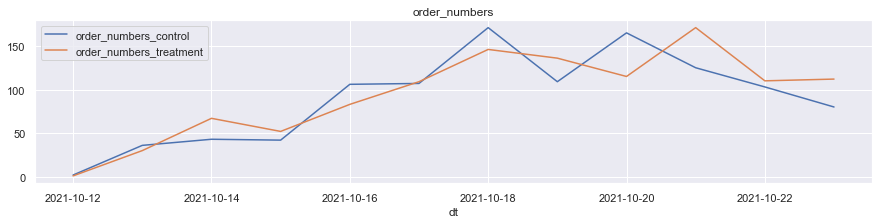

<Figure size 432x288 with 0 Axes>

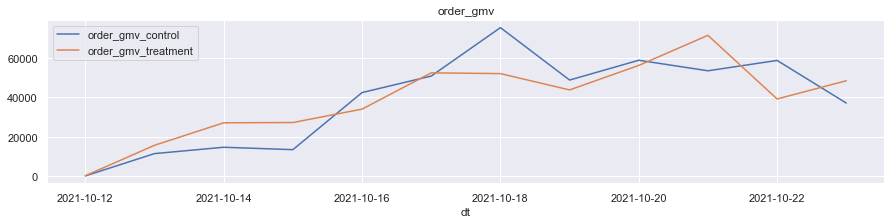

<Figure size 432x288 with 0 Axes>

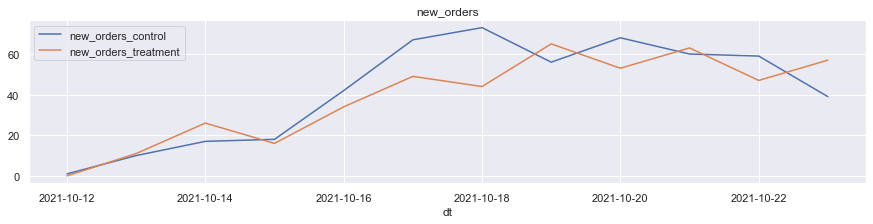

<Figure size 432x288 with 0 Axes>

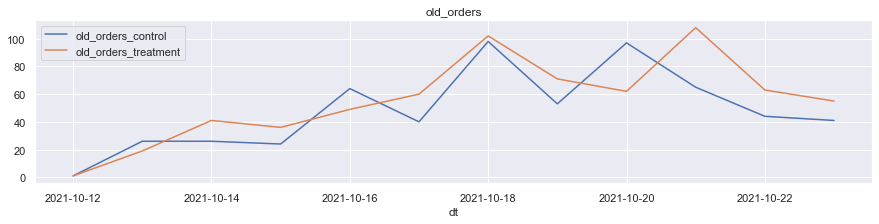

<Figure size 432x288 with 0 Axes>

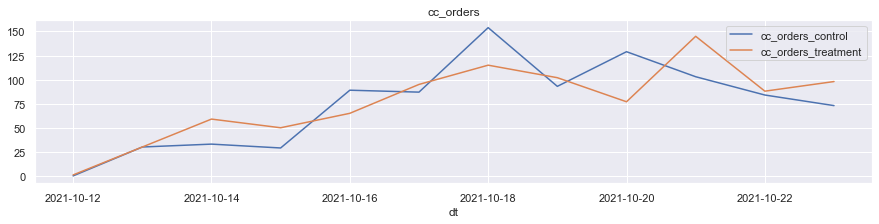

<Figure size 432x288 with 0 Axes>

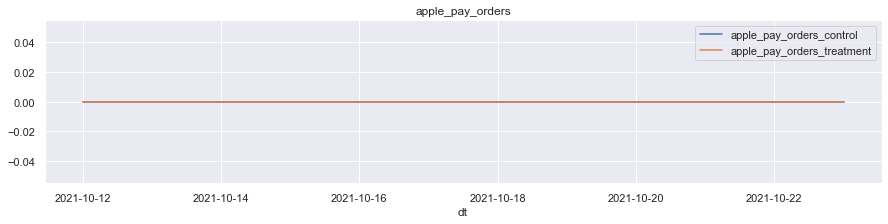

<Figure size 432x288 with 0 Axes>

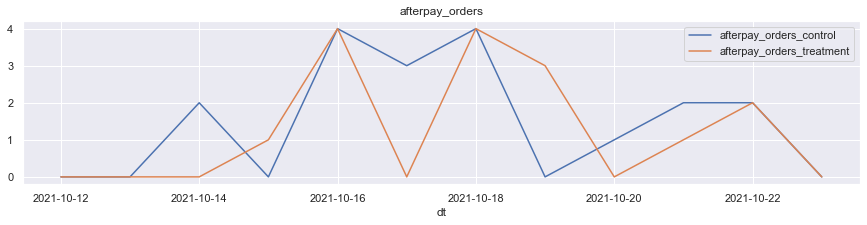

<Figure size 432x288 with 0 Axes>

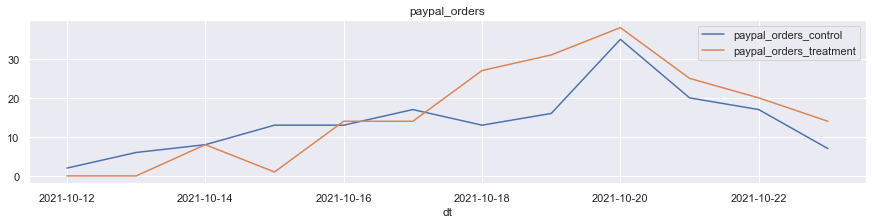

<Figure size 432x288 with 0 Axes>

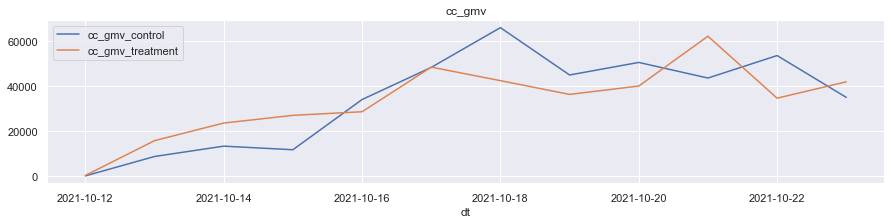

<Figure size 432x288 with 0 Axes>

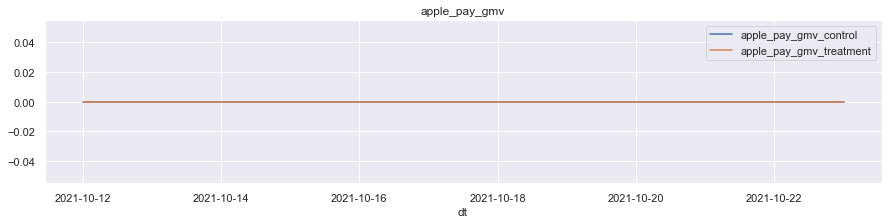

<Figure size 432x288 with 0 Axes>

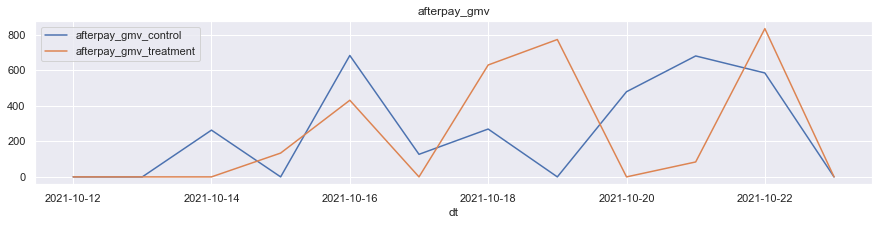

<Figure size 432x288 with 0 Axes>

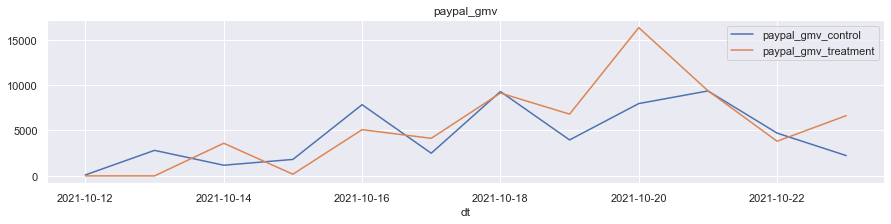

<Figure size 432x288 with 0 Axes>

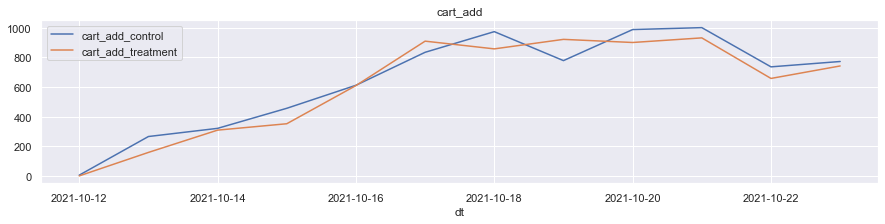

<Figure size 432x288 with 0 Axes>

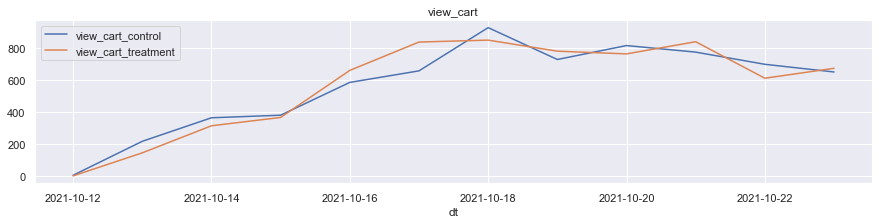

<Figure size 432x288 with 0 Axes>

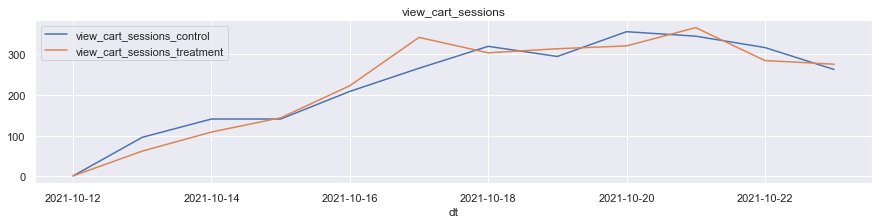

<Figure size 432x288 with 0 Axes>

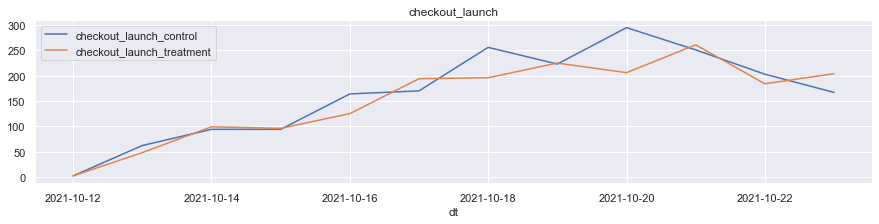

<Figure size 432x288 with 0 Axes>

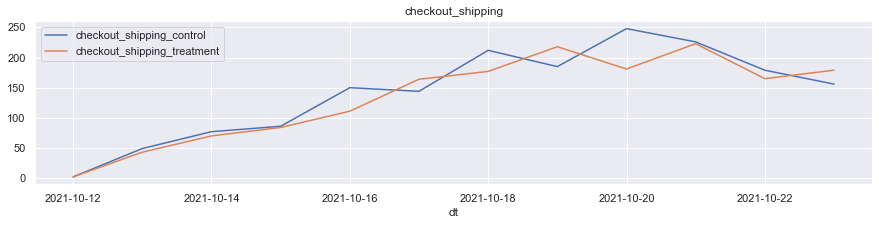

<Figure size 432x288 with 0 Axes>

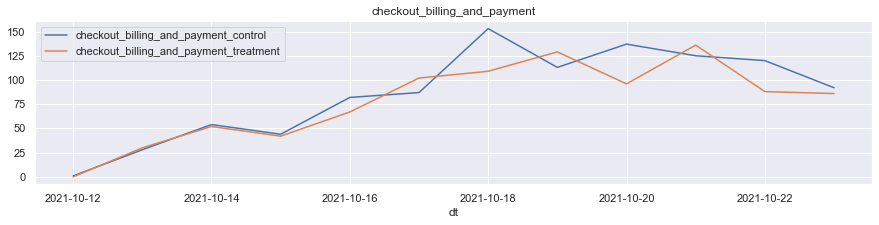

<Figure size 432x288 with 0 Axes>

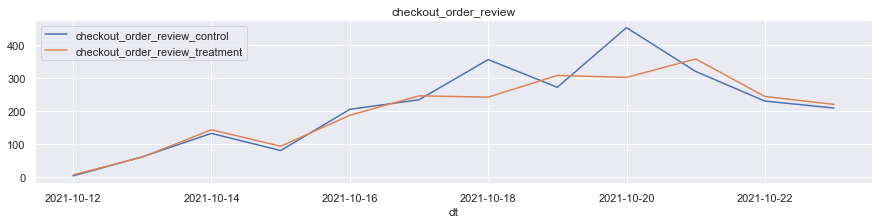

<Figure size 432x288 with 0 Axes>

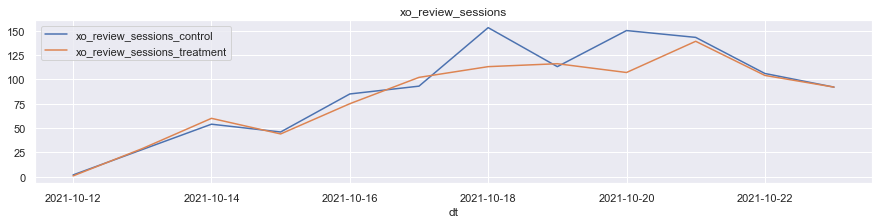

<Figure size 432x288 with 0 Axes>

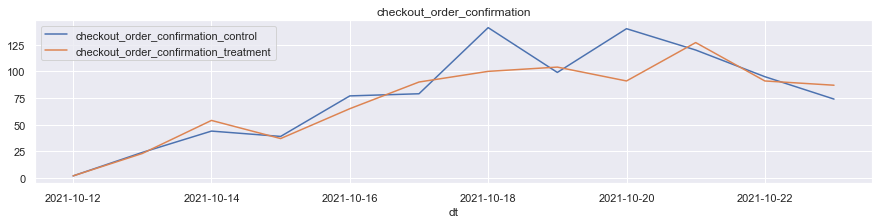

In [57]:
day_by_day(df_dt, col_list, control, treatment)

In [58]:
df_orders = pd.read_sql("""
            with lb as (

                select pmt.house_id, pmt.dt, pmt.final_display_price, th.threshold,  if(final_display_price <= threshold, 'Y', 'N') lowest_badge
                from shop.product_master_table_daily pmt
                left join shop.product_lowest_price_threshold_daily th
                    on pmt.dt = cast(date_add('day', -1, cast(th.dt as date)) as varchar)
                    and pmt.house_id = th.house_id 
            )
            select 
              t0.visitor_id, 
              t0.test_variant,
              t2.dt,
              lb.lowest_badge,
                count(distinct case when checkout_type = 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as new_orders,
                count(distinct case when checkout_type != 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as old_orders,

                count(distinct case when billing_info like '%paymentMethodType":0%' then t2.order_id end) as cc_orders,
                count(distinct case when billing_info like '%paymentMethodType":1%' then t2.order_id end) as apple_pay_orders,
                count(distinct case when billing_info like '%paymentMethodType":4%' then t2.order_id end) as afterpay_orders,
                count(distinct case when billing_info like '%paymentMethodType":3%' then t2.order_id end) as paypal_orders,

                sum(case when billing_info like '%paymentMethodType":0%' then t2.item_gmv end) as cc_gmv,
                sum(case when billing_info like '%paymentMethodType":1%' then t2.item_gmv end) as apple_pay_gmv,
                sum(case when billing_info like '%paymentMethodType":4%' then t2.item_gmv end) as afterpay_gmv,
                sum(case when billing_info like '%paymentMethodType":3%' then t2.item_gmv end) as paypal_gmv,

              count(distinct t2.order_id) as order_numbers, 
              sum(t2.item_gmv) as order_gmv
            from wandajuan.visitor_base_dweb_lowest_price_badge_test t0 
            join  mp_test.order_item_details t2 
              on t0.visitor_id = t2.visitor_id 
              and t2.order_date >= t0.dt 
              and order_date between '2021-10-12' and '2021-10-23' 
            join logs.marketplace_valid_orders_detailed_daily t4
                on t2.order_id = t4.order_id
            left join lb
            on t2.order_date = lb.dt and t2.house_id = lb.house_id
            where t2.status in (0,1,2,3,4,5,20,99) 
              and t2.is_impersonated = 0 
            group by 1, 2, 3, 4
            """, conn)

In [59]:
df_orders.head()

,visitor_id,test_variant,dt,lowest_badge,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,order_numbers,order_gmv
0,c66036db-fb5b-4aa3-98df-375ca9e5b54c,control,2021-10-16,N,3,0,3,0,0,0,679.99,None,NaN,NaN,3,679.99
1,b5cffc37-7bfa-4533-a8ef-37a1fd0c0d2c,treatment,2021-10-19,None,0,1,1,0,0,0,36.00,None,NaN,NaN,1,36.00
2,13386691-c2af-457e-a48e-c75475e85d02,control,2021-10-18,N,1,0,1,0,0,0,249.00,None,NaN,NaN,1,249.00
3,59a25be5-2b95-4711-9506-c942dc1831b5,control,2021-10-18,N,3,0,3,0,0,0,1227.82,None,NaN,NaN,3,1227.82
4,605ee10f-b104-4375-a899-43ba916e6e72,treatment,2021-10-23,N,0,1,1,0,0,0,159.00,None,NaN,NaN,1,159.00


In [62]:
df_orders['lowest_badge'] = df_orders['lowest_badge'].fillna('N')
df_orders.head()

,visitor_id,test_variant,dt,lowest_badge,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,order_numbers,order_gmv
0,c66036db-fb5b-4aa3-98df-375ca9e5b54c,control,2021-10-16,N,3,0,3,0,0,0,679.99,None,NaN,NaN,3,679.99
1,b5cffc37-7bfa-4533-a8ef-37a1fd0c0d2c,treatment,2021-10-19,N,0,1,1,0,0,0,36.00,None,NaN,NaN,1,36.00
2,13386691-c2af-457e-a48e-c75475e85d02,control,2021-10-18,N,1,0,1,0,0,0,249.00,None,NaN,NaN,1,249.00
3,59a25be5-2b95-4711-9506-c942dc1831b5,control,2021-10-18,N,3,0,3,0,0,0,1227.82,None,NaN,NaN,3,1227.82
4,605ee10f-b104-4375-a899-43ba916e6e72,treatment,2021-10-23,N,0,1,1,0,0,0,159.00,None,NaN,NaN,1,159.00


In [70]:
# pd.pivot_table(index='dt', columns = 'test_variant', values=)
df_orders.groupby(['test_variant', 'lowest_badge', 'dt']).sum().unstack(0)

new_orders           old_orders           cc_orders  \
test_variant               control treatment    control treatment   control   
lowest_badge dt                                                               
N            2021-10-12          1         0          1         1         0   
             2021-10-13          9         7         19        17        24   
             2021-10-14         13        18         21        33        25   
             2021-10-15         10         8         17        27        18   
             2021-10-16         31        18         41        33        60   
             2021-10-17         54        33         28        42        71   
             2021-10-18         57        29         77        85       121   
             2021-10-19         44        44         48        61        76   
             2021-10-20         49        41         81        57       101   
             2021-10-21         46        45         53        88        85   
             2021-10-22         39        28         36        47        62   
             2021-10-23         39        57         41        55        73   
Y            2021-10-13          2         4          7         2         7   
             2021-10-14          4         8          6         8         9   
             2021-10-15          8         8          7        11        11   
             2021-10-16         13        16         25        16        32   
             2021-10-17         15        17         12        21        17   
             2021-10-18         16        15         23        16        35   
             2021-10-19         12        21          6        11        18   
             2021-10-20         20        12         17         7        29   
             2021-10-21         16        18         13        23        21   
             2021-10-22         22        23          7        16        23   

                                  apple_pay_orders           afterpay_orders  \
test_variant            treatment          control treatment         control   
lowest_badge dt                                                                
N            2021-10-12         1                0         0               0   
             2021-10-13        24                0         0               0   
             2021-10-14        49                0         0               2   
             2021-10-15        34                0         0               0   
             2021-10-16        41                0         0               4   
             2021-10-17        66                0         0               1   
             2021-10-18        88                0         0               3   
             2021-10-19        83                0         0               0   
             2021-10-20        66                0         0               1   
             2021-10-21       117                0         0               2   
             2021-10-22        62                0         0               2   
             2021-10-23        98                0         0               0   
Y            2021-10-13         6                0         0               0   
             2021-10-14        10                0         0               0   
             2021-10-15        18                0         0               0   
             2021-10-16        24                0         0               0   
             2021-10-17        33                0         0               2   
             2021-10-18        26                0         0               1   
             2021-10-19        19                0         0               0   
             2021-10-20        12                0         0               0   
             2021-10-21        31                0         0               0   
             2021-10-22        29                0         0               0   

                                  paypal_orders

In [71]:
df_orders.groupby(['test_variant', 'lowest_badge', 'dt']).sum().unstack(0).to_clipboard()

In [72]:
df_orders.groupby(['test_variant', 'dt']).sum()

new_orders  old_orders  cc_orders  apple_pay_orders  \
test_variant dt                                                                
control      2021-10-12           1           1          0                 0   
             2021-10-13          11          26         31                 0   
             2021-10-14          17          27         34                 0   
             2021-10-15          18          24         29                 0   
             2021-10-16          44          66         92                 0   
             2021-10-17          69          40         88                 0   
             2021-10-18          73         100        156                 0   
             2021-10-19          56          54         94                 0   
             2021-10-20          69          98        130                 0   
             2021-10-21          62          66        106                 0   
             2021-10-22          61          43         85                 0   
             2021-10-23          39          41         73                 0   
treatment    2021-10-12           0           1          1                 0   
             2021-10-13          11          19         30                 0   
             2021-10-14          26          41         59                 0   
             2021-10-15          16          38         52                 0   
             2021-10-16          34          49         65                 0   
             2021-10-17          50          63         99                 0   
             2021-10-18          44         101        114                 0   
             2021-10-19          65          72        102                 0   
             2021-10-20          53          64         78                 0   
             2021-10-21          63         111        148                 0   
             2021-10-22          51          63         91                 0   
             2021-10-23          57          55         98                 0   

                         afterpay_orders  paypal_orders    cc_gmv  \
test_variant dt                                                     
control      2021-10-12                0              2      0.00   
             2021-10-13                0              6   8619.73   
             2021-10-14                2              8  13211.38   
             2021-10-15                0             13  11616.85   
             2021-10-16                4             14  33915.47   
             2021-10-17                3             18  48184.30   
             2021-10-18                4             13  65856.46   
             2021-10-19                0             16  44823.56   
             2021-10-20                1             36  50398.89   
             2021-10-21                2             20  43460.82   
             2021-10-22                2             17  53321.53   
             2021-10-23                0              7  34872.57   
treatment    2021-10-12                0              0    196.00   
             2021-10-13                0              0  15657.89   
             2021-10-14                0              8  23475.40   
             2021-10-15                1              1  26888.41   
             2021-10-16                4             14  28496.83   
             2021-10-17                0             14  59729.06   
             2021-10-18                4             27  41628.28   
             2021-10-19                3             32  36195.61   
             2021-10-20                0             39  39905.18   
             2021-10-21                1             25  62034.80   
             2021-10-22                2             21  33804.23   
             2021-10-23                0             14  41791.30   

                         afterpay_gmv  paypal_gmv  order_numbers  order_gmv  
test_variant dt                                                        

In [76]:
df_orders.loc[df_orders['lowest_badge']=='Y'].groupby(['test_variant','dt']).sum()

new_orders  old_orders  cc_orders  apple_pay_orders  \
test_variant dt                                                                
control      2021-10-13           2           7          7                 0   
             2021-10-14           4           6          9                 0   
             2021-10-15           8           7         11                 0   
             2021-10-16          13          25         32                 0   
             2021-10-17          15          12         17                 0   
             2021-10-18          16          23         35                 0   
             2021-10-19          12           6         18                 0   
             2021-10-20          20          17         29                 0   
             2021-10-21          16          13         21                 0   
             2021-10-22          22           7         23                 0   
treatment    2021-10-13           4           2          6                 0   
             2021-10-14           8           8         10                 0   
             2021-10-15           8          11         18                 0   
             2021-10-16          16          16         24                 0   
             2021-10-17          17          21         33                 0   
             2021-10-18          15          16         26                 0   
             2021-10-19          21          11         19                 0   
             2021-10-20          12           7         12                 0   
             2021-10-21          18          23         31                 0   
             2021-10-22          23          16         29                 0   

                         afterpay_orders  paypal_orders    cc_gmv  \
test_variant dt                                                     
control      2021-10-13                0              2   2623.00   
             2021-10-14                0              1   3274.50   
             2021-10-15                0              4   4684.62   
             2021-10-16                0              6  10207.82   
             2021-10-17                2              8   4567.28   
             2021-10-18                1              3   7705.19   
             2021-10-19                0              0   8644.36   
             2021-10-20                0              8   7550.57   
             2021-10-21                0              8   9172.51   
             2021-10-22                0              6  15311.85   
treatment    2021-10-13                0              0   3682.61   
             2021-10-14                0              6   2924.73   
             2021-10-15                1              0   8846.74   
             2021-10-16                1              7   7034.29   
             2021-10-17                0              5  11018.12   
             2021-10-18                0              5   7768.31   
             2021-10-19                1             12   7439.46   
             2021-10-20                0              7   5045.88   
             2021-10-21                0             10   9502.40   
             2021-10-22                0             10  10530.87   

                         afterpay_gmv  paypal_gmv  order_numbers    order_gmv  
test_variant dt                                                                
control      2021-10-13          0.00  2115.59000              9   4738.59000  
             2021-10-14          0.00    87.00000             10   3361.50000  
             2021-10-15          0.00   583.14000             15   5267.76000  
             2021-10-16          0.00  1799.60000             38  12007.42000  
             2021-10-17         89.90   994.15000             27   5651.33000  
             2021-10-18         74.00   644.96000             39   8424.15000  
             2021-10-19          0.00     0.00000             18   8644.36000  
             2021-10-20  

In [79]:
gb = df_orders.loc[df_orders['lowest_badge']=='Y'].groupby(['test_variant','dt']).sum()/df_orders.groupby(['test_variant', 'dt']).sum()
gb.unstack(0)

new_orders           old_orders           cc_orders            \
test_variant    control treatment    control treatment   control treatment   
dt                                                                           
2021-10-12          NaN       NaN        NaN       NaN       NaN       NaN   
2021-10-13     0.181818  0.363636   0.269231  0.105263  0.225806  0.200000   
2021-10-14     0.235294  0.307692   0.222222  0.195122  0.264706  0.169492   
2021-10-15     0.444444  0.500000   0.291667  0.289474  0.379310  0.346154   
2021-10-16     0.295455  0.470588   0.378788  0.326531  0.347826  0.369231   
2021-10-17     0.217391  0.340000   0.300000  0.333333  0.193182  0.333333   
2021-10-18     0.219178  0.340909   0.230000  0.158416  0.224359  0.228070   
2021-10-19     0.214286  0.323077   0.111111  0.152778  0.191489  0.186275   
2021-10-20     0.289855  0.226415   0.173469  0.109375  0.223077  0.153846   
2021-10-21     0.258065  0.285714   0.196970  0.207207  0.198113  0.209459   
2021-10-22     0.360656  0.450980   0.162791  0.253968  0.270588  0.318681   
2021-10-23          NaN       NaN        NaN       NaN       NaN       NaN   

             apple_pay_orders           afterpay_orders            \
test_variant          control treatment         control treatment   
dt                                                                  
2021-10-12                NaN       NaN             NaN       NaN   
2021-10-13                NaN       NaN             NaN       NaN   
2021-10-14                NaN       NaN        0.000000       NaN   
2021-10-15                NaN       NaN             NaN  1.000000   
2021-10-16                NaN       NaN        0.000000  0.250000   
2021-10-17                NaN       NaN        0.666667       NaN   
2021-10-18                NaN       NaN        0.250000  0.000000   
2021-10-19                NaN       NaN             NaN  0.333333   
2021-10-20                NaN       NaN        0.000000       NaN   
2021-10-21                NaN       NaN        0.000000  0.000000   
2021-10-22                NaN       NaN        0.000000  0.000000   
2021-10-23                NaN       NaN             NaN       NaN   

             paypal_orders              cc_gmv           afterpay_gmv  \
test_variant       control treatment   control treatment      control   
dt                                                                      
2021-10-12             NaN       NaN       NaN       NaN          NaN   
2021-10-13        0.333333       NaN  0.304302  0.235192          NaN   
2021-10-14        0.125000  0.750000  0.247855  0.124587     0.000000   
2021-10-15        0.307692  0.000000  0.403261  0.329017          NaN   
2021-10-16        0.428571  0.500000  0.300978  0.246845     0.000000   
2021-10-17        0.444444  0.357143  0.094788  0.184468     0.708432   
2021-10-18        0.230769  0.185185  0.117000  0.186611     0.274980   
2021-10-19        0.000000  0.375000  0.192853  0.205535          NaN   
2021-10-20        0.222222  0.179487  0.149816  0.126447     0.000000   
2021-10-21        0.400000  0.400000  0.211052  0.153179     0.000000   
2021-10-22        0.352941  0.476190  0.287161  0.311525     0.000000   
2021-10-23             NaN       NaN       NaN       NaN          NaN   

                       paypal_gmv           order_numbers           order_gmv  \
test_variant treatment    control treatment       control treatment   control   
dt                                                                              
2021-10-12         NaN        NaN       NaN           NaN       NaN       NaN   
2021-10-13         NaN   0.753337       NaN      0.243243  0.200000  0.414647   
2021-10-14         NaN   0.074111  0.475369      0.227273  0.238806  0.229481   
2021-10-15    1.000000   0.321905  0.000000      0.357143  0.351852  0.392286   
2021-10-16    0.222702   0.229788  0.387984      0.345455  0.385542  0.282993   
2021-10-17         NaN   0.398769  0.288517      0.247706  0.3

In [80]:
gb.unstack(0).to_clipboard()